In [1]:
import warnings
import os
import tensorflow as tf
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import talib as ta
import quantstats as qs

In [3]:
df = pd.read_csv("D:/Code/tickers.csv")
df = df[df.tic == "^TNX"]
df = df.drop(["Unnamed: 0", "tic", "day"], axis=1)
df = df.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_values('date', ascending=True, inplace=True)

In [5]:
df['SMA_5'] = ta.SMA(df['Close'], 5)
df['SMA_14'] = ta.SMA(df['Close'], 14)
df['SMA_22'] = ta.SMA(df['Close'], 22)
# df['SMA_41'] = ta.SMA(df['Close'], 41)
# df['SMA_63'] = ta.SMA(df['Close'], 63)
df['EMA_5'] = ta.EMA(df['Close'], 5)
df['EMA_14'] = ta.EMA(df['Close'], 14)
df['EMA_22'] = ta.EMA(df['Close'], 22)
# df['EMA_41'] = ta.EMA(df['Close'], 41)
# df['EMA_63'] = ta.EMA(df['Close'], 63)
df['RSI'] = ta.RSI(df['Close'])
df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = ta.MACD(df['Close'])
df['BBANDS_UPPER'], df['BBANDS_MIDDLE'], df['BBANDS_LOWER'] = ta.BBANDS(df['Close'])
df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'])
df['OBV'] = ta.OBV(df['Close'], df['Volume'])
df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'])

In [6]:
df.isnull().sum()

Open              0
High              0
Low               0
Close             0
Volume            0
SMA_5             4
SMA_14           13
SMA_22           21
EMA_5             4
EMA_14           13
EMA_22           21
RSI              14
MACD             33
MACD_SIGNAL      33
MACD_HIST        33
BBANDS_UPPER      4
BBANDS_MIDDLE     4
BBANDS_LOWER      4
ADX              27
OBV               0
ATR              14
dtype: int64

In [7]:
df.fillna(0, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5727 entries, 2000-01-04 to 2023-09-19
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           5727 non-null   float64
 1   High           5727 non-null   float64
 2   Low            5727 non-null   float64
 3   Close          5727 non-null   float64
 4   Volume         5727 non-null   int64  
 5   SMA_5          5727 non-null   float64
 6   SMA_14         5727 non-null   float64
 7   SMA_22         5727 non-null   float64
 8   EMA_5          5727 non-null   float64
 9   EMA_14         5727 non-null   float64
 10  EMA_22         5727 non-null   float64
 11  RSI            5727 non-null   float64
 12  MACD           5727 non-null   float64
 13  MACD_SIGNAL    5727 non-null   float64
 14  MACD_HIST      5727 non-null   float64
 15  BBANDS_UPPER   5727 non-null   float64
 16  BBANDS_MIDDLE  5727 non-null   float64
 17  BBANDS_LOWER   5727 non-null   flo

In [9]:
# Define the number of episodes for training
Time_Step = 1_000_000
# models_dir = 'D:/Code/Stock/Python/Stock/models/DQN_1'
logdir = 'D:/Code/Stock/Python/Stock/logs/'

# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [10]:
window_size = 35
start_index = window_size
end_train_index = round(len(df)*0.70)
end_val_index = len(df)
initial_money = 10000
commission = 0.005

In [11]:
df.min()

Open                  0.484000
High                  0.538000
Low                   0.398000
Close                 0.499000
Volume                0.000000
SMA_5                 0.000000
SMA_14                0.000000
SMA_22                0.000000
EMA_5                 0.000000
EMA_14                0.000000
EMA_22                0.000000
RSI                   0.000000
MACD                 -0.372297
MACD_SIGNAL          -0.340515
MACD_HIST            -0.088243
BBANDS_UPPER          0.000000
BBANDS_MIDDLE         0.000000
BBANDS_LOWER          0.000000
ADX                   0.000000
OBV             -159900.000000
ATR                   0.000000
dtype: float64

In [12]:
df.max()

Open             6.781000e+00
High             6.823000e+00
Low              6.767000e+00
Close            6.781000e+00
Volume           1.597000e+05
SMA_5            6.737200e+00
SMA_14           6.693000e+00
SMA_22           6.657455e+00
EMA_5            6.732501e+00
EMA_14           6.661299e+00
EMA_22           6.639052e+00
RSI              8.689798e+01
MACD             2.257161e-01
MACD_SIGNAL      2.027204e-01
MACD_HIST        8.470438e-02
BBANDS_UPPER     6.806051e+00
BBANDS_MIDDLE    6.737200e+00
BBANDS_LOWER     6.673132e+00
ADX              6.018119e+01
OBV              1.217600e+06
ATR              1.725980e-01
dtype: float64

In [13]:
overall_max = df.values.max()
overall_min = df.values.min()
print("Overall Maximum Value:", overall_max)
print("Overall Minimum Value:", overall_min)

Overall Maximum Value: 1217600.0
Overall Minimum Value: -159900.0


In [14]:
Discrete(7).sample()

4

In [15]:
Box(low=overall_min, high=overall_max, shape=(window_size, len(df.columns),),dtype=np.float32).sample()

array([[ 7.02054625e+05, -1.42432875e+05,  1.48378500e+05,
         1.61576641e+05,  3.02098812e+05,  1.09289962e+06,
         1.18629838e+06,  1.03426925e+06,  1.18252000e+06,
         4.12753867e+04,  1.05594588e+06,  7.94668062e+05,
         3.67893219e+05,  2.64207406e+05,  1.57986453e+05,
         8.00305312e+05,  4.43156438e+05,  9.29023688e+05,
         1.75518391e+05,  8.90126312e+05,  8.58364188e+05],
       [ 2.71924750e+05,  1.09626188e+06,  1.11683288e+06,
         7.38245938e+05,  5.97661328e+04,  5.64833203e+04,
         1.87851922e+05,  1.21342338e+06,  3.64767094e+05,
         1.21389488e+06,  4.29438094e+05,  4.20199125e+05,
         8.62929188e+05,  7.27301625e+05,  4.44738531e+05,
         1.01643256e+06,  2.55458562e+05,  1.94818906e+05,
         3.74568812e+05,  8.28332250e+05, -2.21424707e+04],
       [ 1.04365625e+06,  1.51057438e+05,  8.05286375e+05,
         1.82613938e+05,  7.16292875e+05,  8.34494250e+05,
         1.18798738e+06,  9.06593000e+05,  7.12657000e

In [16]:
class TradingEnv(Env):
    def __init__(self, start_date, end_date, commision_fee=0.0005, initial_balance=10000, window_size=35, df=df, overall_max=overall_max, overall_min=overall_min):
        self.start = start_date
        self.end = end_date
        self.overall_max = overall_max
        self.overall_min = overall_min
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.current_balance = self.initial_balance
        self.profit = 0
        self.shares_held = 0
        self.reward = 0
        self.window_size = window_size
        self.commision_fee = commision_fee
        self.current_step = self.window_size + 1
        self.action_space = Discrete(7) 
        # 7 actions: [Weak Sell, Sell, Strong Sell, Hold, Weak Buy, Buy, Strong Buy]
        
        self.state_features = ['Low', 'Volume', 'SMA_5', 'SMA_14', 'SMA_22',
                                'EMA_5', 'EMA_14', 'EMA_22', 'RSI', 'MACD', 'MACD_SIGNAL',
                                'MACD_HIST', 'BBANDS_UPPER', 'BBANDS_MIDDLE', 'BBANDS_LOWER', 'ADX', 'OBV', 'ATR']
        num_features = len(self.state_features)

        self.observation_space = Box(
            low=self.overall_min, high=self.overall_max,
            shape=(self.window_size, num_features),
            dtype=np.float32
        )
        

    def step(self, action):
        profit = self.calculate_profit(action)
        if profit > 0:
            self.reward += 1
        else:
            self.reward += -1
        done = self.current_step >= self.df_total_steps
        self.current_step += 1
        observation = self.df.loc[self.current_step - self.window_size:self.current_step - 1][self.state_features].values
        return observation, self.reward, done, {}
    def reset(self):
        self.reward = 0
        self.current_step = self.window_size + 1
        self.current_balance = self.initial_balance
        self.profit = 0
        self.shares_held = 0
        return self.df.loc[self.current_step - self.window_size:self.current_step - 1][self.state_features].values
    def calculate_profit(self, action):
        # Calculate the profit based on the chosen action
        current_price = self.df.loc[self.current_step]['Close']
        previous_price = self.df.loc[self.current_step - 1]['Close']

        if action == 0:  # Weak Sell
            # Calculate profit for selling a fraction of shares (e.g., 25%)
            sell_percentage = 0.25
            shares_sold = self.shares_held * sell_percentage
            sell_value = shares_sold * current_price
            self.current_balance += sell_value
            self.shares_held -= shares_sold

        elif action == 1:  # Sell
            # Calculate profit for selling all shares
            sell_value = self.shares_held * current_price
            self.current_balance += sell_value
            self.shares_held = 0

        elif action == 2:  # Strong Sell
            # Calculate profit for selling all shares and adding a margin
            margin = 0.05  # 5% margin
            sell_value = self.shares_held * current_price * (1 - margin)
            self.current_balance += sell_value
            self.shares_held = 0

        elif action == 3:  # Hold
            # No buying or selling, so profit remains the same
            pass

        elif action == 4:  # Weak Buy
            # Calculate profit for buying a fraction of shares (e.g., 25%)
            buy_percentage = 0.25
            buy_value = self.current_balance * buy_percentage
            self.shares_held += buy_value / current_price
            self.current_balance -= buy_value

        elif action == 5:  # Buy
            # Calculate profit for buying shares with all available balance
            self.shares_held += self.current_balance / current_price
            self.current_balance = 0

        elif action == 6:  # Strong Buy
            # Calculate profit for buying shares with a margin
            margin = 0.05  # 5% margin
            buy_value = self.current_balance * (1 - margin)
            self.shares_held += buy_value / current_price
            self.current_balance -= buy_value

        # Calculate profit for holding shares
        holding_value = self.shares_held * (current_price - previous_price)
        self.profit = holding_value + (self.current_balance - self.initial_balance)

        return self.profit


In [17]:
# class DQNLSTM:
#     def __init__(self, state_dim, action_dim, hidden_units=(64, 64), learning_rate=0.001, discount_factor=0.99):
#         self.state_dim = state_dim
#         self.action_dim = action_dim
#         self.hidden_units = hidden_units
#         self.learning_rate = learning_rate
#         self.discount_factor = discount_factor

#         self.model = self.build_model()
#         self.target_model = self.build_model()
#         self.update_target_model()

#     def build_model(self):
#         model = tf.keras.models.Sequential()
#         model.add(tf.keras.layers.LSTM(self.hidden_units[0], return_sequences=True, input_shape=(None, self.state_dim)))
#         model.add(tf.keras.layers.LSTM(self.hidden_units[1]))
#         model.add(tf.keras.layers.Dense(self.action_dim, activation='linear'))
#         model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate))
#         return model

#     def update_target_model(self):
#         self.target_model.set_weights(self.model.get_weights())

#     def select_action(self, state, epsilon):
#         if np.random.rand() <= epsilon:
#             return np.random.choice(self.action_dim)
#         q_values = self.model.predict(state)
#         return np.argmax(q_values[0])

#     def train(self, replay_buffer, batch_size):
#         if len(replay_buffer) < batch_size:
#             return

#         minibatch = np.array(replay_buffer.sample(batch_size))
#         states = np.vstack(minibatch[:, 0])
#         actions = minibatch[:, 1]
#         rewards = minibatch[:, 2]
#         next_states = np.vstack(minibatch[:, 3])
#         dones = minibatch[:, 4]

#         targets = self.model.predict(states)
#         target_values = self.target_model.predict(next_states)

#         for i in range(batch_size):
#             if dones[i]:
#                 targets[i][int(actions[i])] = rewards[i]
#             else:
#                 targets[i][int(actions[i])] = rewards[i] + self.discount_factor * np.max(target_values[i])

#         self.model.fit(states, targets, nb_epoch=1, verbose=0)

#     def save(self, filename):
#         self.model.save(filename)

#     def load(self, filename):
#         self.model = tf.keras.models.load_model(filename)
#         self.update_target_model()

In [18]:
# env = TradingEnv(start_index, end_train_index, commission, initial_money, window_size, df, overall_max, overall_min)
# # Define agent parameters
# state_dim = env.observation_space.shape[1]
# action_dim = env.action_space.n

# Initialize the DQN agent
# agent = DQNLSTM(state_dim, action_dim, hidden_units=(4, 4), learning_rate=0.001, discount_factor=0.99)

In [19]:
%pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: d:\env\stockreinlearvenv\lib\site-packages
Requires: absl-py, astor, gast, google-pasta, grpcio, keras-applications, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, wheel, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [20]:
# # Define hyperparameters
# num_episodes = 1000
# batch_size = 64
# epsilon = 1.0  # Initial exploration rate
# epsilon_min = 0.01  # Minimum exploration rate
# epsilon_decay = 0.995  # Decay rate for exploration

# replay_buffer = []  # Create a replay buffer to store experiences

# for episode in range(num_episodes):
#     state = env.reset()
#     state = np.reshape(state, (1, window_size, state_dim))
#     done = False
#     total_profit = 0

#     while not done:
#         action = agent.select_action(state, epsilon)
#         next_state, reward, done, _ = env.step(action)
#         next_state = np.reshape(next_state, (1, window_size, state_dim))
#         replay_buffer.append((state, action, reward, next_state, done))
#         state = next_state
#         total_profit += reward

#         # Train the agent using experience replay
#         agent.train(replay_buffer, batch_size)

#     # Decay the exploration rate
#     if epsilon > epsilon_min:
#         epsilon *= epsilon_decay

#     # Print the episode's total profit
#     print(f"Episode {episode + 1}/{num_episodes}, Total Profit: {total_profit}")

# # Save the trained agent
# agent.save("trained_agent.h5")

In [126]:
# val_env = TradingEnv(end_train_index, end_val_index, commission, initial_money, window_size, df, overall_max, overall_min)

# total_val_profit = 0

# for _ in range(num_episodes):
#     state = val_env.reset()
#     state = np.reshape(state, (1, window_size, state_dim))
#     done = False
#     episode_profit = 0

#     while not done:
#         action = agent.select_action(state, 0.0)  # Use epsilon=0 for testing (no exploration)
#         next_state, reward, done, _ = val_env.step(action)
#         next_state = np.reshape(next_state, (1, window_size, state_dim))
#         state = next_state
#         episode_profit += reward

#     total_val_profit += episode_profit

# # Print the total validation profit
# print(f"Total Validation Profit: {total_val_profit}")

In [127]:
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

# Create a training environment
train_env = TradingEnv(start_index, end_train_index, commission, initial_money, window_size, df, overall_max, overall_min)

# Create a validation environment
val_env = TradingEnv(end_train_index, end_val_index, commission, initial_money, window_size, df, overall_max, overall_min)

# Wrap the environments in a DummyVecEnv
train_env = DummyVecEnv([lambda: train_env])
val_env = DummyVecEnv([lambda: val_env])

# Define and train a DQN model using Stable Baselines3
model = DQN("MlpPolicy", train_env, verbose=1)  # Use "MlpPolicy" or another policy
model.learn(total_timesteps=int(Time_Step))  # Set the number of training steps

# Save the trained model
model.save("dqn_trained_model")

Using cpu device


d:\Env\StockReinLearVenv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "
d:\Env\StockReinLearVenv\lib\site-packages\stable_baselines3\common\buffers.py:230: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.06GB > 2.17GB
  "This system does not have apparently enough memory to store the complete "


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.784    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 766      |
|    time_elapsed     | 29       |
|    total_timesteps  | 22764    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 817      |
|    time_elapsed     | 55       |
|    total_timesteps  | 45528    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.351    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 601      |
|    time_elapsed     | 113      |
|    total_timesteps  | 68292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss           

In [128]:
%pip show stable-baselines3

Name: stable-baselines3Note: you may need to restart the kernel to use updated packages.

Version: 2.0.0
Summary: Pytorch version of Stable Baselines, implementations of reinforcement learning algorithms.
Home-page: https://github.com/DLR-RM/stable-baselines3
Author: Antonin Raffin
Author-email: antonin.raffin@dlr.de
License: MIT
Location: d:\env\stockreinlearvenv\lib\site-packages
Requires: cloudpickle, gymnasium, matplotlib, numpy, pandas, torch, typing-extensions
Required-by: 


In [129]:
# Evaluate the model on the validation environment
num_episodes = 10  # Number of episodes for evaluation
episode_rewards = []

for _ in range(num_episodes):
    obs = val_env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = val_env.step(action)
        total_reward += reward

    episode_rewards.append(total_reward)

mean_reward = np.mean(episode_rewards)
std_reward = np.std(episode_rewards)

print(f"Mean Reward on Validation: {mean_reward}")
print(f"Standard Deviation of Reward on Validation: {std_reward}")

Mean Reward on Validation: -12189939.0
Standard Deviation of Reward on Validation: 3914538.0


In [ ]:
# Plot the rewards
plt.plot(range(num_episodes), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Validation Rewards')
plt.grid(True)
plt.show()

In [21]:
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import numpy as np

# Create a validation environment
val_env = TradingEnv(end_train_index, end_val_index, commission, initial_money, window_size, df, overall_max, overall_min)

# Wrap the environment in a DummyVecEnv
val_env = DummyVecEnv([lambda: val_env])

# Load the trained model
model = DQN.load("dqn_trained_model")

# Evaluate the model on the validation environment
num_episodes = 10  # Number of episodes for evaluation
episode_rewards = []

for _ in range(num_episodes):
    obs = val_env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = val_env.step(action)
        total_reward += reward

    episode_rewards.append(total_reward)

mean_reward = np.mean(episode_rewards)
std_reward = np.std(episode_rewards)

print(f"Mean Reward on Validation: {mean_reward}")
print(f"Standard Deviation of Reward on Validation: {std_reward}")

d:\Env\StockReinLearVenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Env\StockReinLearVenv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "
d:\Env\StockReinLearVenv\lib\site-packages\stable_baselines3\common\buffers.py:230: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.06GB > 2.15GB
  "This system does not have apparently enough memory to store the complete "


Mean Reward on Validation: -11615178.0
Standard Deviation of Reward on Validation: 4782370.5


In [22]:
type(episode_rewards)

list

In [23]:
episode_rewards

[array([-11970844.], dtype=float32),
 array([-14040262.], dtype=float32),
 array([-11551338.], dtype=float32),
 array([-14077370.], dtype=float32),
 array([-15126516.], dtype=float32),
 array([-12376752.], dtype=float32),
 array([-11913596.], dtype=float32),
 array([2319436.], dtype=float32),
 array([-13111034.], dtype=float32),
 array([-14303506.], dtype=float32)]

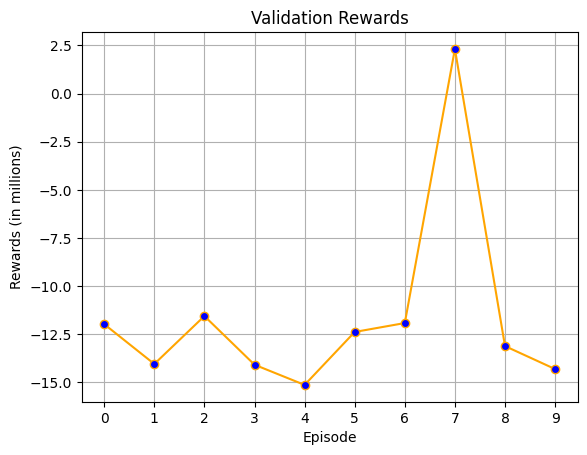

In [2]:
import matplotlib.pyplot as plt
import numpy as np

episode_rewards = [
    np.array([-11970844.], dtype=float),
    np.array([-14040262.], dtype=float),
    np.array([-11551338.], dtype=float),
    np.array([-14077370.], dtype=float),
    np.array([-15126516.], dtype=float),
    np.array([-12376752.], dtype=float),
    np.array([-11913596.], dtype=float),
    np.array([2319436.], dtype=float),
    np.array([-13111034.], dtype=float),
    np.array([-14303506.], dtype=float)
]

# Rescale the rewards for better visualization
rescaled_rewards = [reward[0] / 1e6 for reward in episode_rewards]  # Dividing by 1e6 for scaling

plt.plot(rescaled_rewards, color='orange', marker='o', mfc='blue')  # Plot the rescaled data
plt.xticks(range(len(episode_rewards)))  # Set the tick frequency on the x-axis

plt.ylabel('Rewards (in millions)')  # Set the label for the y-axis
plt.xlabel('Episode')  # Set the label for the x-axis
plt.title("Validation Rewards")  # Set the title of the graph
plt.grid(True)
plt.show()  # Display the graph

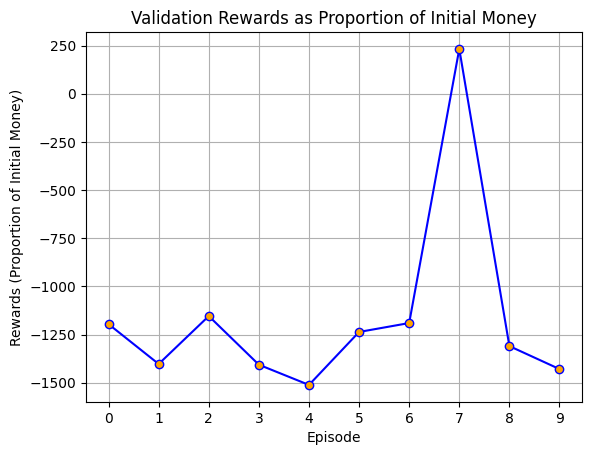

In [5]:
import matplotlib.pyplot as plt
import numpy as np

episode_rewards = [
    np.array([-11970844.], dtype=float),
    np.array([-14040262.], dtype=float),
    np.array([-11551338.], dtype=float),
    np.array([-14077370.], dtype=float),
    np.array([-15126516.], dtype=float),
    np.array([-12376752.], dtype=float),
    np.array([-11913596.], dtype=float),
    np.array([2319436.], dtype=float),
    np.array([-13111034.], dtype=float),
    np.array([-14303506.], dtype=float)
]

# Initial amount of money
initial_money = 10000

# Calculate rewards as a proportion of the initial money
rewards_proportion = [(reward[0] + initial_money) / initial_money for reward in episode_rewards]

plt.plot(rewards_proportion, color='blue', marker='o', mfc='orange')  # Plot the rewards as a proportion
plt.xticks(range(len(episode_rewards)))  # Set the tick frequency on the x-axis

plt.ylabel('Rewards (Proportion of Initial Money)')  # Set the label for the y-axis
plt.xlabel('Episode')  # Set the label for the x-axis
plt.title("Validation Rewards as Proportion of Initial Money")  # Set the title of the graph
plt.grid(True)
plt.show()  # Display the graph

In [24]:
plt.plot(episode_rewards, color='magenta', marker='o',mfc='pink' ) #plot the data
plt.xticks(range(0,len(episode_rewards)+1, 1)) #set the tick frequency on x-axis

plt.ylabel('data') #set the label for y axis
plt.xlabel('index') #set the label for x-axis
plt.title("Plotting a list") #set the title of the graph
plt.show() #display the graph

: 

In [ ]:
# Plot the rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Validation Rewards')
plt.grid(True)
plt.show()